# Demo some of the functionality of lumos-ncpt-tools

### 1) Load up some data! 
- Instantiate a NCPT class object with data from one test battery
    - The demo data is all data from NCPT battery 25
- Display some summary info on the dataset and subtests

### 2) Process and plot the scores 
- Filter out outlier raw scores
- Plot the raw score distributions before and after outlier removal
- Plot a histogram of the Grand Index (composite score)
- Plot the Grand Index vs. age

### 3) Miscellaneous 
- Show the meaning of the numeric education levels 
- Filter out participants who did not complete the test battery

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from lumos_ncpt_tools.ncpt import NCPT
from lumos_ncpt_tools.utils import load_data

## 1) Load up some data

In [2]:
# Load all of the data from one NCPT battery (demo_data.csv = battery 26)
data_directory = './'
data_fn = 'demo_data.csv'
df = load_data(data_directory, data_fn)

# Instantiate a NCPT object, display some basic info
ncpt = NCPT(df)
del df
ncpt.report_stats()
ncpt.get_subtest_info()
ncpt.df.head(10)

Data summary
------------
N users: 5275
N tests: 5275
N subtests: 36048
DataFrame columns: ['user_id', 'age', 'gender', 'education_level', 'country', 'test_run_id', 'battery_id', 'results_timestamp', 'specific_subtest_id', 'raw_score', 'time_of_day', 'grand_index']

Subtest information
-------------------
Subtest ID 27: Divided visual attention, v1, N scores = 5088
Subtest ID 28: Forward memory span, v1, N scores = 5236
Subtest ID 29: Arithmetic reasoning, v1, N scores = 5275
Subtest ID 30: Grammatical reasoning, v1, N scores = 5145
Subtest ID 31: Progressive matrices, v1, N scores = 5063
Subtest ID 32: Go/no-go, v2, N scores = 5074
Subtest ID 33: Reverse memory span, v1, N scores = 5167



,user_id,age,gender,education_level,country,test_run_id,battery_id,results_timestamp,specific_subtest_id,raw_score,time_of_day,grand_index
0,14335196,30.0,m,4.0,US,626579,25,2013-04-22T13:23:48Z,29,36.0,13,NaN
1,14335196,30.0,m,4.0,US,626579,25,2013-04-22T15:28:28Z,28,8.0,13,NaN
2,17096000,53.0,f,5.0,US,653018,25,2015-12-21T22:42:03Z,29,27.0,22,122.369460
3,17096000,53.0,f,5.0,US,653018,25,2015-12-21T22:45:06Z,28,6.0,22,122.369460
4,17096000,53.0,f,5.0,US,653018,25,2015-12-21T22:47:43Z,33,5.0,22,122.369460
5,17096000,53.0,f,5.0,US,653018,25,2015-12-21T22:49:09Z,30,14.0,22,122.369460
6,17096000,53.0,f,5.0,US,653018,25,2015-12-21T22:51:32Z,27,8.0,22,122.369460
7,17096000,53.0,f,5.0,US,653018,25,2015-12-21T22:53:14Z,32,457.0,22,122.369460
8,17096000,53.0,f,5.0,US,653018,25,2015-12-21T23:16:10Z,31,16.0,22,122.369460
9,18254130,21.0,m,3.0,US,409707,25,2015-12-21T19:56:08Z,29,9.0,19,98.850789


## 2) Process and plot the scores

### Check for outliers

Subtest ID 33: N outliers = 3


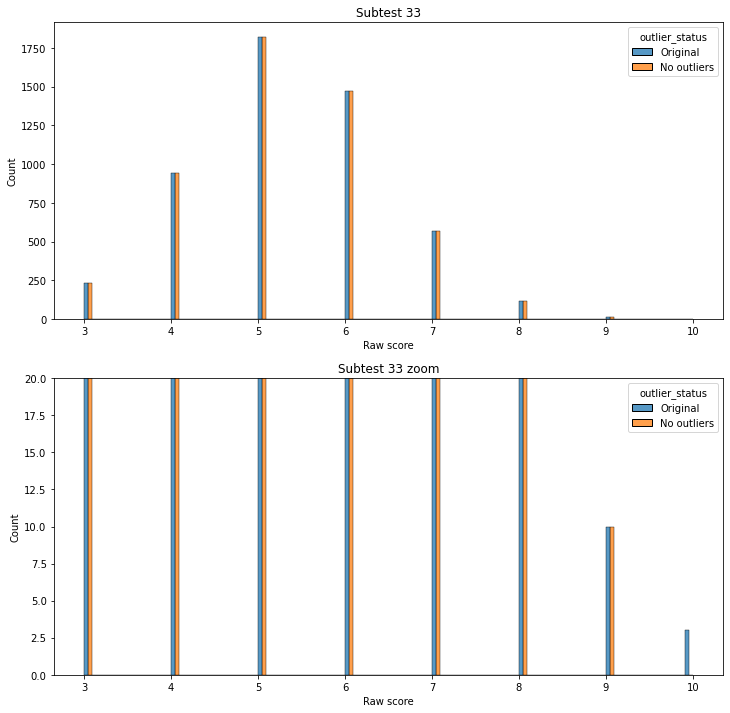

In [3]:
# Remove outlier raw scores using the median absolute deviation (MAD) method
# Note: Depending on the intended application, this may or may not be a sensible thing to do.
outlier_threshold = 5 # fairly conservative threshold
outlier_method = 'MAD'
n_bins = 10
outlier_subtests = [33] # Reverse memory span v1
zoom_ylim = [0, 20]
filt_df = ncpt.filter_outliers_by_subtest('raw_score', outlier_threshold, 
                                          outlier_subtests, method=outlier_method)

# Plot the raw score distributions before and after outlier removal
for sub in outlier_subtests:
    orig_sub_df = ncpt.df.query('specific_subtest_id == @sub')
    orig_sub_df = orig_sub_df.assign(outlier_status='Original')
    filt_sub_df = filt_df.query('specific_subtest_id == @sub')
    filt_sub_df = filt_sub_df.assign(outlier_status='No outliers')
    plot_df = pd.concat([orig_sub_df, filt_sub_df])
    plot_df.reset_index(drop=True, inplace=True)
    fig, axes = plt.subplots(2, 1, figsize=(12, 12))
    for ax_ind, ax in enumerate(axes):
        sns.histplot(plot_df, x='raw_score', hue='outlier_status', multiple='dodge', 
                     ax=ax)
        ax.set_xlabel('Raw score')
        ax.set_ylabel('Count')
        if ax_ind == 1:
            ax.set_ylim(zoom_ylim)
            ax.set_title(f'Subtest {sub} zoom')
        else:
            ax.set_title(f'Subtest {sub}')
    plt.show()


### Plot a histogram of the Grand Index 

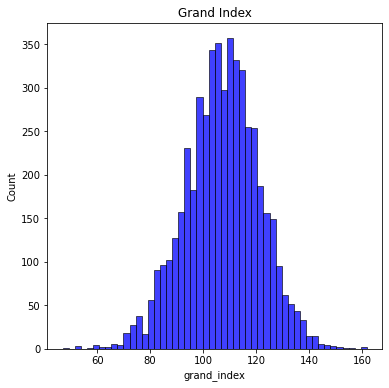

Mean Grand Index: 107.19883063651542
Std. dev. of Grand Index: 14.0102620081692


In [4]:
# Plot the distribution of the Grand Index
GI_df = ncpt.df.drop_duplicates(subset=['test_run_id'])
fig, axes = plt.subplots(1, 1, figsize=(6, 6))
sns.histplot(GI_df['grand_index'], color='b', kde=False, ax=axes, bins=50)
axes.set_title('Grand Index')
plt.show()

# Stats
print(f"Mean Grand Index: {GI_df['grand_index'].mean()}")
print(f"Std. dev. of Grand Index: {GI_df['grand_index'].std()}")

### Plot the Grand Index vs. age
- Red line is best linear fit

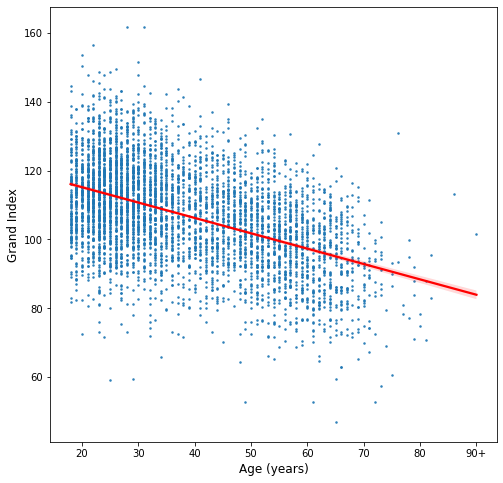

In [5]:
fig, axes = plt.subplots(1, 1, figsize=(8, 8))
fontsize = 12
sns.regplot(x='age', y='grand_index', data=GI_df, ax=axes, marker='.', 
            scatter_kws={'s': 10}, line_kws={'color': 'r'})
axes.set_xlabel('Age (years)', fontsize=fontsize)
axes.set_ylabel('Grand Index', fontsize=fontsize)
axes.set_xticks([20, 30, 40, 50, 60, 70, 80, 90])
axes.set_xticklabels(['20', '30', '40', '50', '60', '70', '80', '90+'])
plt.show()

## 3) Miscellaneous

In [6]:
# Display the meaning of the numeric education levels
ncpt.get_education_info()

# Filter out participants who did not complete the test battery
filt_df, exclude_df = ncpt.filter_by_completeness()
print(f'Filtered out {len(exclude_df)} subtests \n')

Key for education levels
------------------------
1: Some high school
2: High school diploma / GED
3: Some college
4: College degree
5: Professional degree
6: Master's degree
7: Ph.D.
8: Associate's degree
99: Other

Filtered out 607 subtests 

